In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy
from torch.nn.functional import pad
import torch.nn.init as init
import copy
from torch import autograd
from torchvision.utils import make_grid
import os
from torchdiffeq import odeint_adjoint as odeint



device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}



class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t

    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h 
    return h




In [39]:

def sample_rademacher_like(y):
    return torch.randint(low=0, high=2, size=y.shape).to(y) * 2 - 1

def _flip(x, dim):
    indices = [slice(None)] * x.dim()
    indices[dim] = torch.arange(x.size(dim) - 1, -1, -1, dtype=torch.long, device=x.device)
    return x[tuple(indices)]


def sample_gaussian_like(y):
    return torch.randn_like(y)


def divergence_bf(dx, y, **unused_kwargs):
    sum_diag = 0.
    for i in range(y.shape[1]):
        sum_diag += torch.autograd.grad(dx[:, i].sum(), y, create_graph=True)[0].contiguous()[:, i].contiguous()
    return sum_diag.contiguous()

def divergence_approx(f, y, e=None):
    e_dzdx = torch.autograd.grad(f, y, e, create_graph=True)[0]
    e_dzdx_e = e_dzdx * e
    approx_tr_dzdx = e_dzdx_e.view(y.shape[0], -1).sum(dim=1)
    return approx_tr_dzdx

class ODEfunc(nn.Module):

    def __init__(self, diffeq, divergence_fn="approximate", residual=False, rademacher=False):
        super(ODEfunc, self).__init__()
        assert divergence_fn in ("brute_force", "approximate")

        # self.diffeq = diffeq_layers.wrappers.diffeq_wrapper(diffeq)
        self.diffeq = diffeq
        self.residual = residual
        self.rademacher = rademacher

        if divergence_fn == "brute_force":
            self.divergence_fn = divergence_bf
        elif divergence_fn == "approximate":
            self.divergence_fn = divergence_approx

        self.register_buffer("_num_evals", torch.tensor(0.))

    def before_odeint(self, e=None):
        self._e = e
        self._num_evals.fill_(0)

    def num_evals(self):
        return self._num_evals.item()

    def forward(self, t, states):
        assert len(states) >= 2
        y = states[0]

        # increment num evals
        self._num_evals += 1

        # convert to tensor
        # t = torch.tensor(t).type_as(y)
        t = t.clone().detach().to(dtype=y.dtype)
        batchsize = y.shape[0]

        # Sample and fix the noise.
        if self._e is None:
            if self.rademacher:
                self._e = sample_rademacher_like(y)
            else:
                self._e = sample_gaussian_like(y)

        with torch.set_grad_enabled(True):
            y.requires_grad_(True)
            t.requires_grad_(True)
            for s_ in states[2:]:
                s_.requires_grad_(True)
            dy = self.diffeq(t, y, *states[2:])
            # Hack for 2D data to use brute force divergence computation.
            if not self.training and dy.view(dy.shape[0], -1).shape[1] == 2:
                divergence = divergence_bf(dy, y).view(batchsize, 1)
            else:
                divergence = self.divergence_fn(dy, y, e=self._e).view(batchsize, 1)
        if self.residual:
            dy = dy - y
            divergence -= torch.ones_like(divergence) * torch.tensor(np.prod(y.shape[1:]), dtype=torch.float32
                                                                     ).to(divergence)
        return tuple([dy, -divergence] + [torch.zeros_like(s_).requires_grad_(True) for s_ in states[2:]])

class RegularizedODEfunc(nn.Module):
    def __init__(self, odefunc, regularization_fns):
        super(RegularizedODEfunc, self).__init__()
        self.odefunc = odefunc
        self.regularization_fns = regularization_fns

    def before_odeint(self, *args, **kwargs):
        self.odefunc.before_odeint(*args, **kwargs)

    def forward(self, t, state):
        class SharedContext(object):
            pass

        with torch.enable_grad():
            x, logp = state[:2]
            x.requires_grad_(True)
            logp.requires_grad_(True)
            dstate = self.odefunc(t, (x, logp))
            if len(state) > 2:
                dx, dlogp = dstate[:2]
                reg_states = tuple(reg_fn(x, logp, dx, dlogp, SharedContext) for reg_fn in self.regularization_fns)
                return dstate + reg_states
            else:
                return dstate

    @property
    def _num_evals(self):
        return self.odefunc._num_evals

class CNF(nn.Module):
    def __init__(self, odefunc, T=1.0, train_T=False, regularization_fns=None, solver='dopri5', atol=1e-5, rtol=1e-5):
        super(CNF, self).__init__()
        if train_T:
            self.register_parameter("sqrt_end_time", nn.Parameter(torch.sqrt(torch.tensor(T))))
        else:
            self.register_buffer("sqrt_end_time", torch.sqrt(torch.tensor(T)))

        nreg = 0
        if regularization_fns is not None:
            odefunc = RegularizedODEfunc(odefunc, regularization_fns)
            nreg = len(regularization_fns)
        self.odefunc = odefunc
        self.nreg = nreg
        self.regularization_states = None
        self.solver = solver
        self.atol = atol
        self.rtol = rtol
        self.test_solver = solver
        self.test_atol = atol
        self.test_rtol = rtol
        self.solver_options = {}

    def forward(self, z, logpz=None, integration_times=None, reverse=False):

        if logpz is None:
            _logpz = torch.zeros(z.shape[0], 1).to(z)
        else:
            _logpz = logpz

        if integration_times is None:
            integration_times = torch.tensor([0.0, self.sqrt_end_time * self.sqrt_end_time]).to(z)
        if reverse:
            integration_times = _flip(integration_times, 0)

        # Refresh the odefunc statistics.
        self.odefunc.before_odeint()

        # Add regularization states.
        reg_states = tuple(torch.tensor(0).to(z) for _ in range(self.nreg))

        if self.training:
            state_t = odeint(
                self.odefunc,
                (z, _logpz) + reg_states,
                integration_times.to(z),
                atol=self.atol,
                rtol=self.rtol,
                method=self.solver,
                options=self.solver_options,
            )
        else:
            state_t = odeint(
                self.odefunc,
                (z, _logpz),
                integration_times.to(z),
                atol=self.test_atol,
                rtol=self.test_rtol,
                method=self.test_solver,
            )

        if len(integration_times) == 2:
            state_t = tuple(s[1] for s in state_t)

        z_t, logpz_t = state_t[:2]
        self.regularization_states = state_t[2:]

        if logpz is not None:
            return z_t, logpz_t
        else:
            return z_t

    def get_regularization_states(self):
        reg_states = self.regularization_states
        self.regularization_states = None
        return reg_states

    def num_evals(self):
        return self.odefunc._num_evals.item()

In [40]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = ScoreNet()

    def forward(self, t, x, ode_system_flag=False):
        batch_t=   torch.ones(x.shape[0], device=device) * t
        dx = self.net(x, batch_t)

        f=dx.reshape(x.shape[0],-1)

        divergence_f=torch.zeros(x.shape[0],device=device)

        v=torch.randn(f.shape).to(device)
        vf=torch.sum(f*v, dim=1)

        print("------------------")
        a=autograd.grad(vf.sum(),x,create_graph=True)[0].reshape(x.shape[0],-1)
        divergence_f=torch.sum(a*v, dim=1)
        d_log_det=divergence_f.reshape(-1,1)
        if ode_system_flag:
            return (dx,d_log_det)
        else: 
            return dx

# def ode_cat_vat(odefun_f,):

In [41]:
def vis_MNIST(z,time_interval=False):
    samples=z.clamp(0.0, 1.0).cpu().detach()
    if time_interval:
        plt.figure(figsize=(12,2))
        sample_grid = make_grid(samples, nrow=z.shape[0])

        
    else: 
        plt.figure(figsize=(8,2))
        sample_grid = make_grid(samples, nrow=4)

    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.show()

In [42]:

import functools
from torch.optim import Adam,AdamW
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from torch.optim.lr_scheduler import OneCycleLR
# from torchdiffeq import odeint


# odefun_f = torch.nn.DataParallel(ODEFunc())
# odefun_f = odefun_f.to(device)

odefun_f = ODEFunc().to(device)



n_epochs =   10#@param {'type':'integer'}
## size of a mini-batch
batch_size =  128 #@param {'type':'integer'}
## learning rate
lr=1e-3 #@param {'type':'number'}
d=28*28*1
tspan=[0,1]
nt=8
h=(tspan[1]-tspan[0])/nt
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optim = Adam(odefun_f.parameters(), lr=lr)

# optim=AdamW(f_theta.parameters(),lr=lr)
# scheduler=OneCycleLR(optim,lr,total_steps=n_epochs*len(data_loader),pct_start=0.25,anneal_strategy='cos')


tqdm_epoch = tqdm.trange(n_epochs)


  0%|          | 0/10 [02:57<?, ?it/s]


In [46]:
diffeq = ScoreNet().to(device)

odefunc =ODEfunc(
                    diffeq=diffeq,
                    divergence_fn="approximate",
                    residual=False,
                    rademacher=False,
                )

cnf = CNF(
                    odefunc=odefunc,
                    T=1.0,
                    train_T=False,
                    regularization_fns=None,
                    solver='dopri5',
                    atol=1e-5, 
                    rtol=1e-5
                )

for x, y in data_loader:
    x=x.to(device)
    zero = torch.zeros(x.shape[0], 1).to(device)
    z, delta_logp = cnf(x, zero)
    break

RuntimeError: The size of tensor a (28) must match the size of tensor b (128) at non-singleton dimension 4

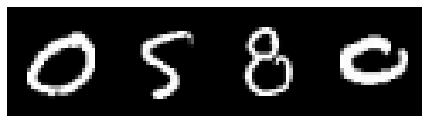

------------------


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
for x, y in data_loader:
    x_0 = x[0:4,:,:,:].to(device).requires_grad_(True)
    vis_MNIST(x_0)
    t_span_sol = torch.tensor([0., 1.]).to(device)
    z_T=odeint(odefun_f , x_0, t_span_sol,method='dopri5',atol=1e-6, rtol=1e-3)[-1,:,:,:,:]
    vis_MNIST(z_T)

    #plot for single
    x_0_single = x[0,:,:,:].unsqueeze(0).to(device).requires_grad_(True)
    t_span_sol = torch.linspace(0.,1.,9)
    z_T_full=odeint(odefun_f , x_0_single, t_span_sol,method='dopri5',atol=1e-6, rtol=1e-3).squeeze(1)
    vis_MNIST(z_T_full,time_interval=True)

    


    break


In [ ]:
def log_Gaussian(x,d):
    return -d/2*math.log(2*math.pi)-torch.sum(x**2,dim=1).reshape(-1,1)/2

def grad_log_Gaussian(x):
    return -x


x=torch.randn((1000,784))
print(torch.mean(log_Gaussian(x,d=784)))




tensor(-1112.1021)


In [ ]:
from tqdm import tqdm


for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}:")
    with tqdm(data_loader, unit="batch") as tepoch:
        for batch in tepoch:
            x,y=batch
            x = x.to(device)
       
            x.requires_grad_(True)
            
            z_t=x
            l_t=torch.zeros(x.shape[0],1).to(device)
            cat_var_init=(z_t,l_t)

    
            t_span_sol = torch.tensor([0., 1.]).to(device)
            z_T=odeint(odefun_f , z_t, t_span_sol,method='dopri5',atol=1e-6, rtol=1e-3)
            print(z_T.shape)

            
  
            # print(cat_var_T[0].shape)


            break


            optim.zero_grad()
            norms = torch.sum((z_t**2).reshape(x.shape[0],-1),dim=1).view(-1,1)
            loss=torch.mean(-l_t+1/2*norms+d/2*math.log(2*math.pi))
            loss.backward()
            optim.step()
            # scheduler.step()

            llh_record.append(loss.detach().cpu()/math.log(2)/d+8)
            tepoch.set_description('Loss: {:5f} '.format(loss.detach().cpu()/math.log(2)/d+8))
            # tepoch.set_postfix(loss=loss.item())
    break
    torch.save(f_theta.state_dict(), 'experiment/MNIST.pth')
    if (epoch+1) % 200 == 0:
            for p in optim.param_groups:
                p['lr'] /= 2
            print("lr: ", p['lr'])





Epoch 1/10:


  0%|          | 0/469 [00:03<?, ?batch/s]

torch.Size([2, 128, 1, 28, 28])


In [ ]:

# def plot_loss(llh_record,log_flag=True):

#     plt.plot(llh_record, label='likelihood')
#     if log_flag:
#         plt.yscale("log")
    
#     plt.legend()
#     plt.show()
# # plot_loss(llh_record)
# plot_loss(llh_record,log_flag=False)

In [ ]:


# for x, y in data_loader:
#     x = x[0:5,:,:,:].to(device)
#     x.requires_grad_(True)

#     samples=x[0:4,:,:,:].clamp(0.0, 1.0).cpu().detach()
#     sample_grid = make_grid(samples, nrow=4)
#     plt.figure(figsize=(8,2))
#     plt.axis('off')
#     plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
#     plt.show()

#     z_T=x[0,:,:,:].unsqueeze(0)

#     z_t=x
#     l_t=torch.zeros(x.shape[0],1).to(device)
#     for k in range(nt):
#         tk=h*k
#         z_t,l_t = stepRK4(odefun, z_t, l_t , f_theta, tk, tk+h)
    
#     for k in range(nt):
#         tk=1-k*h
#         z_t,l_t = stepRK4(odefun, z_t, l_t , f_theta, tk, tk-h)

#     samples=z_t[0:4,:,:,:].clamp(0.0, 1.0).cpu().detach()
#     sample_grid = make_grid(samples, nrow=4)
#     plt.figure(figsize=(8,2))
#     plt.axis('off')
#     plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
#     plt.show()
#     break

In [ ]:

# x=torch.randn(16,1,28,28).to(device)
# x.requires_grad_(True)

# zFull = torch.zeros(*x.shape , nt+1, device=x.device, dtype=x.dtype) # make tensor of size z.shape[0], z.shape[1], nt

# z_t = x
# l_t=torch.zeros(x.shape[0],1).to(device)

# for k in range(nt):
#     tk=1-k*h
#     z_t,l_t = stepRK4(odefun, z_t, l_t , f_theta, tk, tk-h)

# samples=z_t.clamp(0.0, 1.0).cpu().detach()



# sample_grid = make_grid(samples, nrow=int(np.sqrt(16)))

# plt.figure(figsize=(10,10))
# plt.axis('off')
# plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
# plt.show()



# samples=zFull[0:16,:,:,:,-1].clamp(0.0, 1.0).cpu().detach()
# %matplotlib inline

# sample_grid = make_grid(samples, nrow=int(np.sqrt(16)))

# plt.figure(figsize=(10,10))
# plt.axis('off')
# plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
# plt.show()